In [4]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import os
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

In [ ]:
train = pd.read_csv('C:/intensiv/train.csv', low_memory=False) 
valid = pd.read_csv('C:/intensiv/valid.csv', low_memory=False) 

In [3]:
train_f = pd.read_csv('C:/intensiv/train.csv', low_memory=False) 
valid_f = pd.read_csv('C:/intensiv/valid.csv', low_memory=False) 


In [ ]:
def remove_outliers_iqr(df, columns=None, threshold=3):
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns
    
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25) 
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1 
        
        lower_bound = Q1 - threshold * IQR 
        upper_bound = Q3 + threshold * IQR 
        
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

train_cleaned_no_outliers = remove_outliers_iqr(train)
train_cleaned_no_outliers.to_csv('C:/intensiv/train.csv', index=False)

In [ ]:

def remove_outliers_iqr(df, columns=None, threshold=3):
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns 
    
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25) 
        Q3 = df[col].quantile(0.75)  
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR  
        upper_bound = Q3 + threshold * IQR  
        
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean


valid_cleaned_no_outliers = remove_outliers_iqr(valid)
valid_cleaned_no_outliers.to_csv('C:/intensiv/valid.csv', index=False)

In [ ]:
train_missing_fraction = train.isnull().mean()
valid_missing_fraction = valid.isnull().mean()

combined_missing_fraction = pd.concat([train_missing_fraction, valid_missing_fraction], axis=1).max(axis=1)

plt.figure(figsize=(12, 8))
sns.heatmap(train.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Пропуски данных Train", fontsize=16)
plt.xlabel("Колонки")
plt.ylabel("Строки")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(valid.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Пропуски данных Valid", fontsize=16)
plt.xlabel("Колонки")
plt.ylabel("Строки")
plt.show()

In [ ]:
threshold = 0.7

train_missing_fraction = train.isnull().mean()
valid_missing_fraction = valid.isnull().mean()

combined_missing_fraction = pd.concat([train_missing_fraction, valid_missing_fraction], axis=1).max(axis=1)
columns_to_drop = combined_missing_fraction[combined_missing_fraction > threshold].index

train_cleaned = train.drop(columns=columns_to_drop)
valid_cleaned = valid.drop(columns=columns_to_drop)

def has_mixed_types(column):
    types = set(column.dropna().map(type))
    return float in types and str in types

mixed_type_columns_train = [col for col in train_cleaned.columns if has_mixed_types(train_cleaned[col])]
mixed_type_columns_valid = [col for col in valid_cleaned.columns if has_mixed_types(valid_cleaned[col])]

columns_to_drop_mixed = set(mixed_type_columns_train).union(mixed_type_columns_valid)
train_cleaned = train_cleaned.drop(columns=columns_to_drop_mixed)
valid_cleaned = valid_cleaned.drop(columns=columns_to_drop_mixed)

train_cleaned.to_csv('train_cleaned.csv', index=False)
valid_cleaned.to_csv('valid_cleaned.csv', index=False)

Заполнение

In [5]:
for col in valid_f.columns:
    if valid_f[col].dtype in ['float64', 'int64']:
        valid_f[col] = valid_f[col].fillna(valid_f[col].median())
    elif valid_f[col].dtype == 'object':
        valid_f[col] = valid_f[col].fillna('unknown')

In [6]:
for col in train_f.columns:
    if train_f[col].dtype in ['float64', 'int64']: 
        train_f[col] = train_f[col].fillna(train_f[col].median())
    elif train_f[col].dtype == 'object': 
        train_f[col] = train_f[col].fillna('unknown')

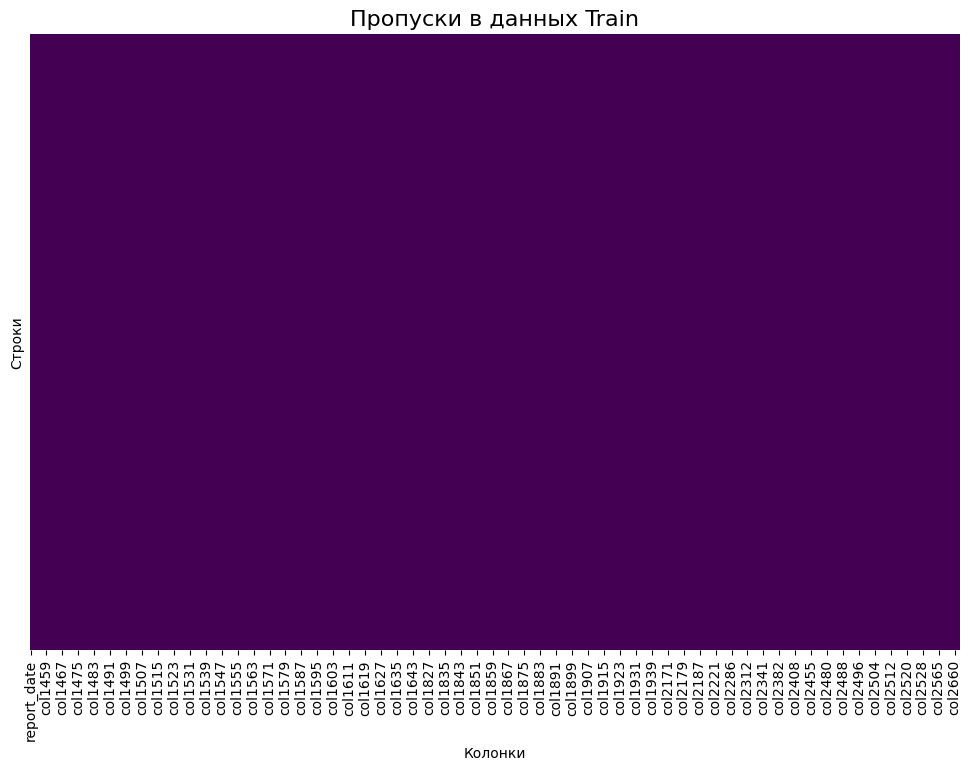

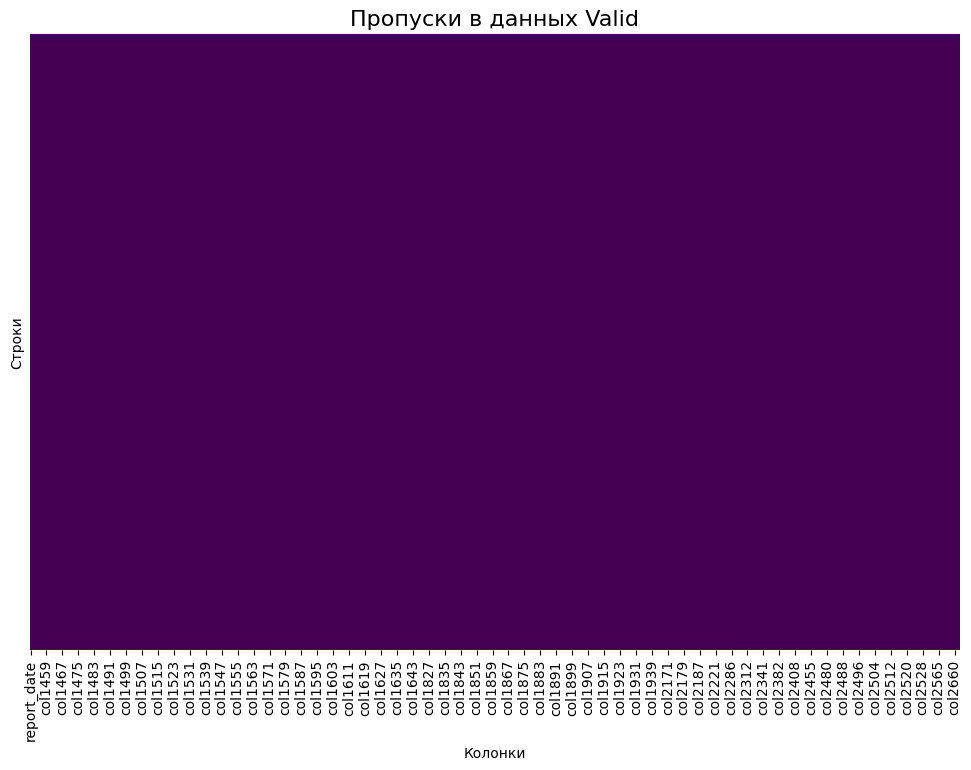

In [7]:
train_missing_fraction = train_f.isnull().mean()
valid_missing_fraction = valid_f.isnull().mean()

combined_missing_fraction = pd.concat([train_missing_fraction, valid_missing_fraction], axis=1).max(axis=1)

plt.figure(figsize=(12, 8))
sns.heatmap(train_f.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Пропуски в данных Train", fontsize=16)
plt.xlabel("Колонки")
plt.ylabel("Строки")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(valid_f.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Пропуски в данных Valid", fontsize=16)
plt.xlabel("Колонки")
plt.ylabel("Строки")
plt.show()


In [8]:
train_f

,report_date,client_id,target,col1453,col1455,col1456,col1457,col1458,col1459,col1460,...,col2566,col2582,col2583,col2584,col2588,col2589,col2590,col2660,col2661,col2662
0,2022-11-01,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
1,2022-11-01,5,0,1,0.0,0.0,0.0,0.0,0.0,1.0,...,5903704.0,362.0,362.0,362.0,362.0,362.0,362.0,7616803.0,7616803.0,7616803.0
2,2022-05-01,6,0,0,0.0,0.0,0.0,0.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
3,2022-09-01,7,0,0,1.0,1.0,1.0,1.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
4,2022-08-01,8,0,0,0.0,0.0,0.0,0.0,0.0,4.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14451,2022-07-01,1241,0,0,0.0,0.0,0.0,0.0,2.0,2.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
14452,2022-09-01,1969,1,0,0.0,0.0,0.0,0.0,0.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
14453,2022-02-01,7116,1,0,0.0,1.0,1.0,1.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
14454,2021-08-01,7117,0,0,0.0,0.0,0.0,0.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0


In [9]:
valid_f

,report_date,client_id,target,col1453,col1455,col1456,col1457,col1458,col1459,col1460,...,col2566,col2582,col2583,col2584,col2588,col2589,col2590,col2660,col2661,col2662
0,2023-04-01,2,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,4981252.0,240.0,240.0,240.0,240.0,240.0,240.0,4941670.0,4941670.0,4941670.0
1,2023-05-01,4,0,0,0.0,0.0,1.0,1.0,1.0,1.0,...,11789500.0,360.0,360.0,360.0,360.0,360.0,360.0,11789500.0,11789500.0,11789500.0
2,2023-05-01,9,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,6443607.5,348.0,348.0,348.0,348.0,348.0,348.0,7000000.0,7000000.0,7000000.0
3,2023-03-01,12,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5
4,2023-03-01,14,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,10391000.0,360.0,360.0,360.0,362.0,362.0,362.0,10391000.0,10391000.0,10391000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,2023-04-01,4366,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,3500000.0,360.0,360.0,360.0,360.0,360.0,360.0,3500000.0,3500000.0,3500000.0
3638,2023-04-01,8298,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5
3639,2023-03-01,835,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5
3640,2023-03-01,8300,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5


CatBoostClassifier

In [10]:
X = train_f.drop(columns=['client_id', 'target', 'report_date'])
y = train_f['target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

X[categorical_features] = X[categorical_features].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

catboost_model = CatBoostClassifier(
    iterations=500,     
    learning_rate=0.05, 
    depth=8, 
    random_state=42,
    cat_features=categorical_features,
    verbose=50,
    auto_class_weights='Balanced'
)

catboost_model.fit(X_train, y_train)

test_preds = catboost_model.predict_proba(X_test)[:, 1]

test_score = roc_auc_score(y_test, test_preds)
print(f"ROC-AUC на тестовых данных: {test_score:.4f}")

submission = pd.DataFrame({'client_id': train_f.loc[X_test.index, 'client_id'], 'score': test_preds})
submission.to_csv('submission_catboost.csv', index=False)

0:	learn: 0.6669328	total: 389ms	remaining: 3m 14s
50:	learn: 0.3292430	total: 5.56s	remaining: 48.9s
100:	learn: 0.2442775	total: 10.3s	remaining: 40.9s
150:	learn: 0.1881098	total: 15.7s	remaining: 36.2s
200:	learn: 0.1314515	total: 21s	remaining: 31.3s
250:	learn: 0.0871486	total: 26.6s	remaining: 26.4s
300:	learn: 0.0596308	total: 31.7s	remaining: 21s
350:	learn: 0.0449570	total: 40.8s	remaining: 17.3s
400:	learn: 0.0343882	total: 46.7s	remaining: 11.5s
450:	learn: 0.0277558	total: 52.7s	remaining: 5.73s
499:	learn: 0.0234603	total: 58.3s	remaining: 0us
ROC-AUC на тестовых данных: 0.9304
Результаты сохранены в submission_catboost.csv


In [11]:
X_valid = valid_f.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y_valid = valid_f['target']

valid_preds = catboost_model.predict_proba(X_valid)[:, 1]

valid_score = roc_auc_score(y_valid, valid_preds)
print(f"ROC-AUC на valid данных: {valid_score:.4f}")

submission_valid = pd.DataFrame({
    'client_id': valid_f['client_id'],
    'score': valid_preds
})

submission_valid.to_csv('submission_valid_catboost.csv', index=False)

ROC-AUC на valid данных: 0.6695
Результаты сохранены в submission_valid_catboost.csv


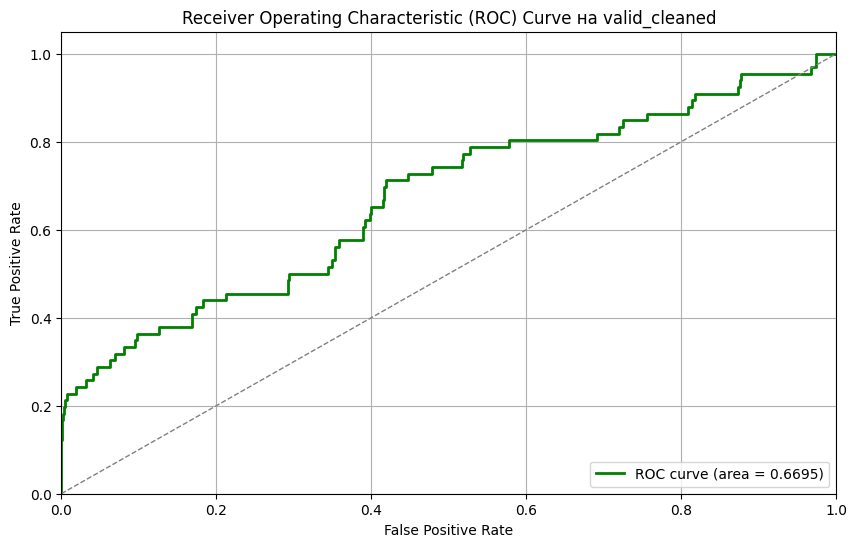

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_valid, valid_preds)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc_score(y_valid, valid_preds):.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve на valid_cleaned')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
columns_to_check = train_f.columns.difference(['report_date', 'client_id', 'target'])
train_no_duplicates = train_f.drop_duplicates(subset=columns_to_check)

In [14]:
train_no_duplicates

,report_date,client_id,target,col1453,col1455,col1456,col1457,col1458,col1459,col1460,...,col2566,col2582,col2583,col2584,col2588,col2589,col2590,col2660,col2661,col2662
0,2022-11-01,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
1,2022-11-01,5,0,1,0.0,0.0,0.0,0.0,0.0,1.0,...,5903704.0,362.0,362.0,362.0,362.0,362.0,362.0,7616803.0,7616803.0,7616803.0
2,2022-05-01,6,0,0,0.0,0.0,0.0,0.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
3,2022-09-01,7,0,0,1.0,1.0,1.0,1.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
4,2022-08-01,8,0,0,0.0,0.0,0.0,0.0,0.0,4.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14451,2022-07-01,1241,0,0,0.0,0.0,0.0,0.0,2.0,2.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
14452,2022-09-01,1969,1,0,0.0,0.0,0.0,0.0,0.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
14453,2022-02-01,7116,1,0,0.0,1.0,1.0,1.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0
14454,2021-08-01,7117,0,0,0.0,0.0,0.0,0.0,1.0,1.0,...,5807425.0,242.0,242.0,242.0,242.0,242.0,242.0,6244578.0,6146773.5,6225550.0


In [ ]:
columns_to_check = valid_f.columns.difference(['report_date', 'client_id', 'target'])
valid_no_duplicates = valid_f.drop_duplicates(subset=columns_to_check)

In [16]:
valid_no_duplicates

,report_date,client_id,target,col1453,col1455,col1456,col1457,col1458,col1459,col1460,...,col2566,col2582,col2583,col2584,col2588,col2589,col2590,col2660,col2661,col2662
0,2023-04-01,2,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,4981252.0,240.0,240.0,240.0,240.0,240.0,240.0,4941670.0,4941670.0,4941670.0
1,2023-05-01,4,0,0,0.0,0.0,1.0,1.0,1.0,1.0,...,11789500.0,360.0,360.0,360.0,360.0,360.0,360.0,11789500.0,11789500.0,11789500.0
2,2023-05-01,9,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,6443607.5,348.0,348.0,348.0,348.0,348.0,348.0,7000000.0,7000000.0,7000000.0
3,2023-03-01,12,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5
4,2023-03-01,14,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,10391000.0,360.0,360.0,360.0,362.0,362.0,362.0,10391000.0,10391000.0,10391000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,2023-04-01,4366,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,3500000.0,360.0,360.0,360.0,360.0,360.0,360.0,3500000.0,3500000.0,3500000.0
3638,2023-04-01,8298,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5
3639,2023-03-01,835,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5
3640,2023-03-01,8300,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,6443607.5,360.0,360.0,360.0,300.0,300.0,300.0,6841532.0,6600000.0,6733329.5


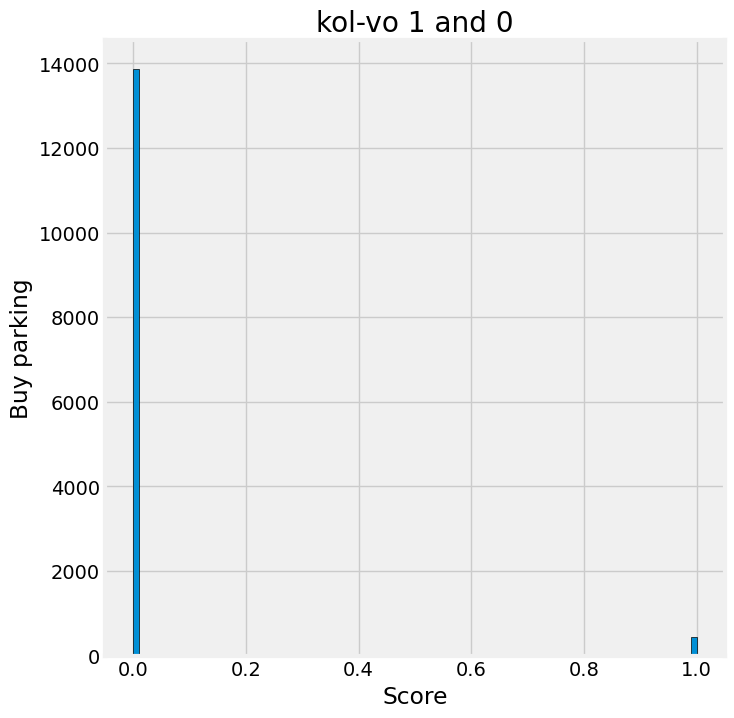

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

data = train_no_duplicates.rename(columns={'target': 'score'})

plt.style.use('fivethirtyeight')
plt.hist(data['score'].dropna(), bins=100, edgecolor='k')
plt.xlabel('Score')
plt.ylabel('Buy parking')
plt.title('kol-vo 1 and 0')

plt.show()

In [18]:
print(y.value_counts(normalize=True))


target
0    0.96984
1    0.03016
Name: proportion, dtype: float64


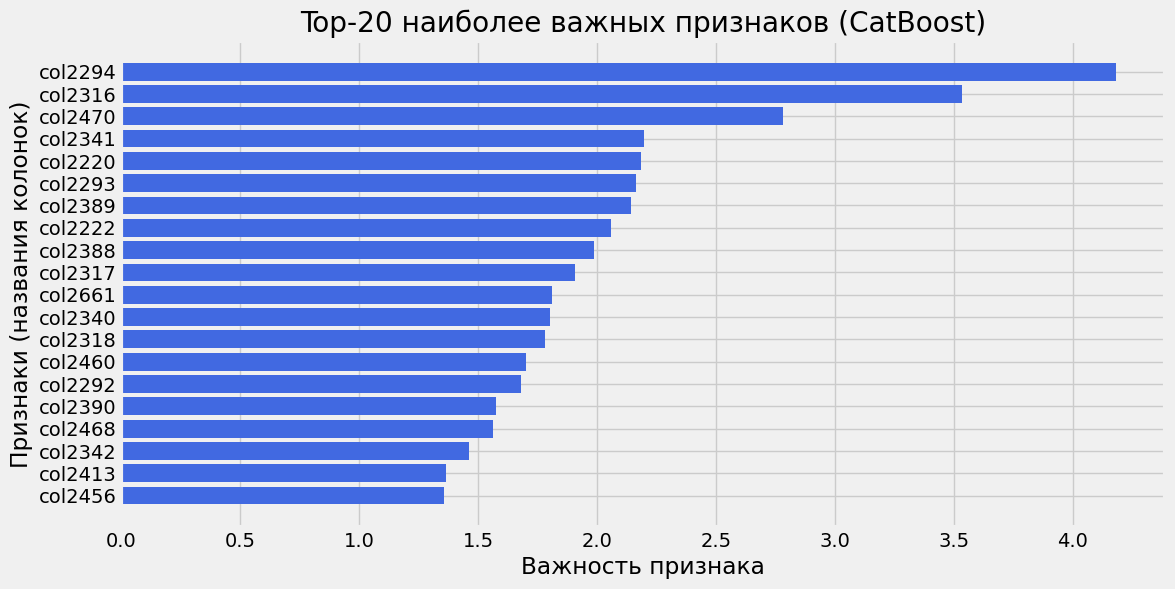

In [19]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importances': catboost_model.get_feature_importance()#ВАЖНА
})

top_features = feature_importance.sort_values(by="Importances", ascending=False).head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_features['Feature'], top_features['Importances'], color='royalblue')
plt.gca().invert_yaxis()
plt.title("Top-20 наиболее важных признаков (CatBoost)")
plt.xlabel("Важность признака")
plt.ylabel("Признаки (названия колонок)")
plt.show()


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

X_train[categorical_columns] = X_train[categorical_columns].astype(str)

ordinal_encoder = OrdinalEncoder()
encoded_data = ordinal_encoder.fit_transform(X_train[categorical_columns])
X_train[categorical_columns] = encoded_data.astype(int)

categorical_columns = X_test.select_dtypes(include=['object']).columns.tolist()
X_test[categorical_columns] = X_test[categorical_columns].astype(str)

ordinal_encoder = OrdinalEncoder()
encoded_data = ordinal_encoder.fit_transform(X_test[categorical_columns])
X_test[categorical_columns] = encoded_data.astype(int)

Баланс классов в сбалансированной обучающей выборке:
target
0    0.5
1    0.5
Name: proportion, dtype: float64


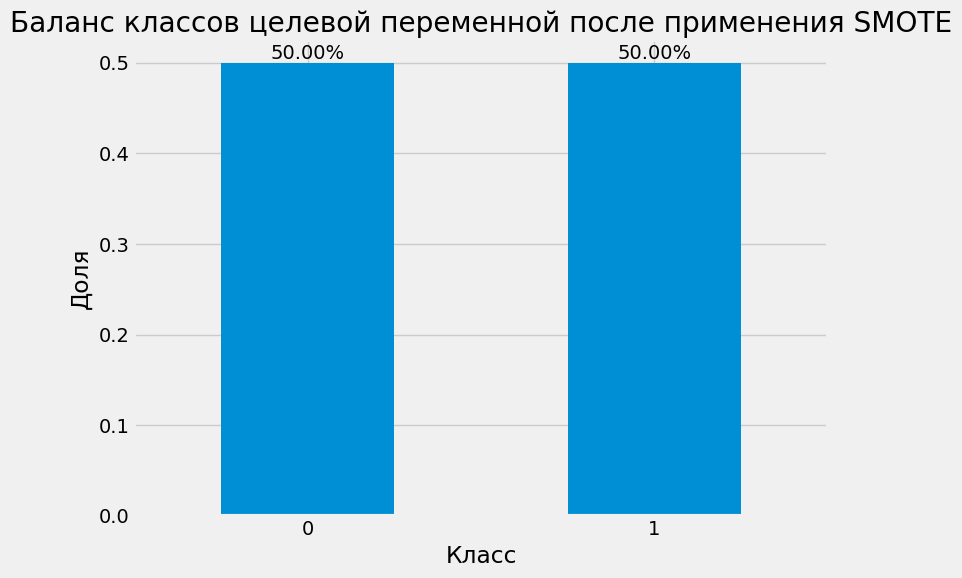

In [23]:
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

class_balance_balanced = y_train.value_counts(normalize=True)
print("Баланс классов в сбалансированной обучающей выборке:")
print(class_balance_balanced)

plt.figure(figsize=(8, 6))
class_balance_balanced.plot(kind='bar')
plt.title('Баланс классов целевой переменной после применения SMOTE')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
for i, v in enumerate(class_balance_balanced):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [24]:
from sklearn.preprocessing import OrdinalEncoder

categorical_columns = X_valid.select_dtypes(include=['object']).columns.tolist()
X_valid[categorical_columns] = X_valid[categorical_columns].astype(str)

ordinal_encoder = OrdinalEncoder()
encoded_data = ordinal_encoder.fit_transform(X_valid[categorical_columns])
X_valid[categorical_columns] = encoded_data.astype(int)

categorical_columns = X_test.select_dtypes(include=['object']).columns.tolist()
X_test[categorical_columns] = X_test[categorical_columns].astype(str)

ordinal_encoder = OrdinalEncoder()
encoded_data = ordinal_encoder.fit_transform(X_test[categorical_columns])
X_test[categorical_columns] = encoded_data.astype(int)

Баланс классов в сбалансированной обучающей выборке:
target
0    0.5
1    0.5
Name: proportion, dtype: float64


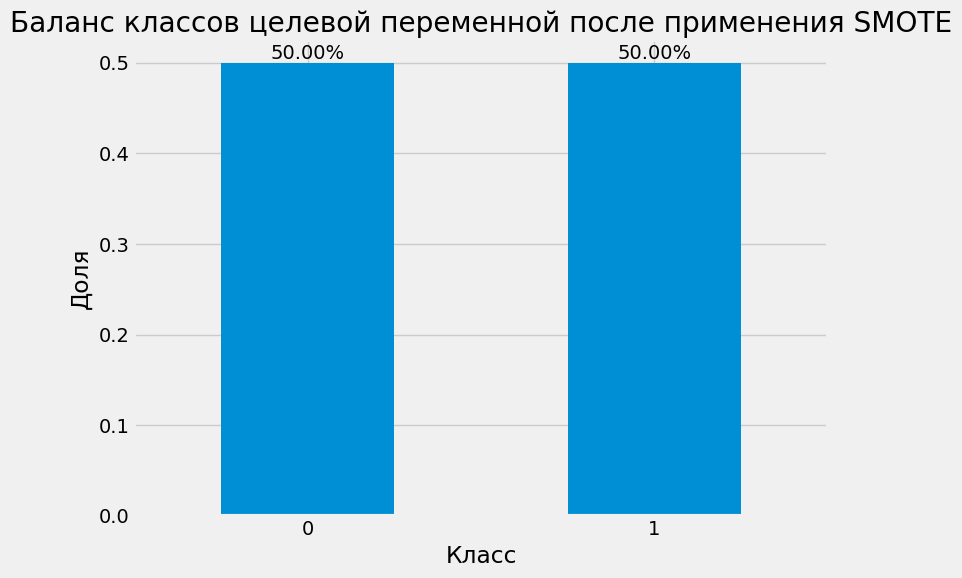

In [25]:
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

smote = SMOTE(random_state=42)
X_valid, y_valid = smote.fit_resample(X_valid, y_valid)
class_balance_balanced = y_valid.value_counts(normalize=True)


plt.figure(figsize=(8, 6))
class_balance_balanced.plot(kind='bar')
plt.title('Баланс классов целевой переменной после применения SMOTE')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
for i, v in enumerate(class_balance_balanced):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

RandomForestClassifier после ребаланса

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc
from sklearn.preprocessing import OrdinalEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

X_new = train_no_duplicates.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y = train_no_duplicates['target']

X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=42, stratify=y
)

categorical_columns = X_train.select_dtypes(include=['object']).columns
ordinal_encoder = OrdinalEncoder()
X_train[categorical_columns] = ordinal_encoder.fit_transform(X_train[categorical_columns].astype(str))
X_test[categorical_columns] = ordinal_encoder.transform(X_test[categorical_columns].astype(str))

random_forest_model = RandomForestClassifier(
    random_state=42
)

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', random_forest_model)
])

param_distributions = {
    'rf__n_estimators': [100, 200, 300, 500],#Колво
    'rf__max_depth': [None, 10, 20, 30, 50],#глубина
    'rf__min_samples_split': [2, 5, 10], #разбиение
    'rf__min_samples_leaf': [1, 2, 4],             
    'rf__class_weight': [None, 'balanced']
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,#Колво кмб
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=2,
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\nROC-AUC на тестовых данных:", roc_auc_score(y_test, y_pred_proba))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры модели: {'rf__n_estimators': 300, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_depth': None, 'rf__class_weight': 'balanced'}

ROC-AUC на тестовых данных: 0.9532875054902253

Classification Report на тестовых данных:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2774
           1       0.87      0.60      0.71        87

    accuracy                           0.98      2861
   macro avg       0.93      0.80      0.85      2861
weighted avg       0.98      0.98      0.98      2861




ROC-AUC на valid данных: 0.7878617875812828

Classification Report на valid данных:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3565
           1       1.00      0.11      0.19        66

    accuracy                           0.98      3631
   macro avg       0.99      0.55      0.59      3631
weighted avg       0.98      0.98      0.98      3631



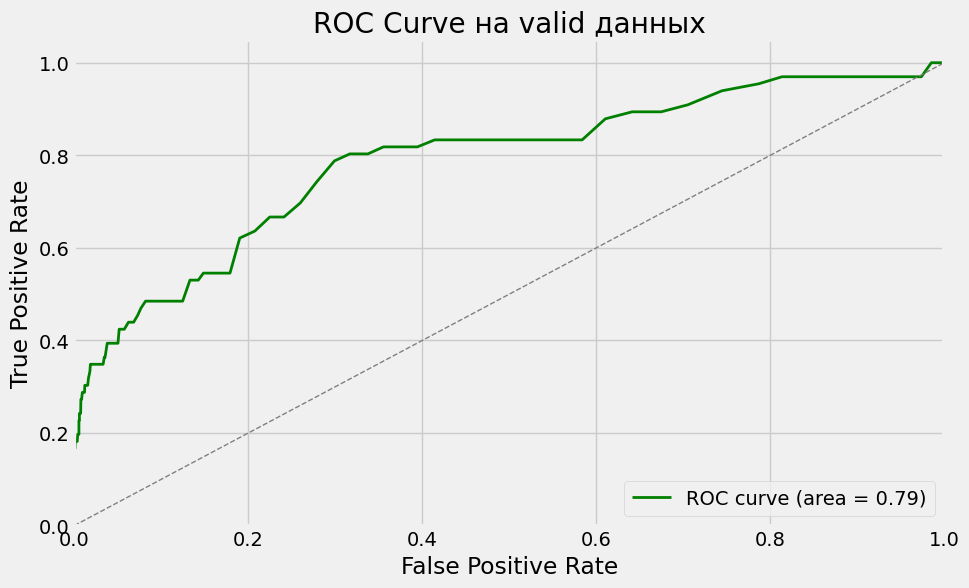

In [27]:
X_valid = valid_no_duplicates.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y_valid = valid_no_duplicates['target']

X_valid[categorical_columns] = ordinal_encoder.transform(X_valid[categorical_columns].astype(str))

y_valid_pred = best_model.predict(X_valid)
y_valid_pred_proba = best_model.predict_proba(X_valid)[:, 1]

roc_auc_valid = roc_auc_score(y_valid, y_valid_pred_proba)
print("\nROC-AUC на valid данных:", roc_auc_valid)

fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_pred_proba)
roc_auc_valid_curve = auc(fpr_valid, tpr_valid)

plt.figure(figsize=(10, 6))
plt.plot(fpr_valid, tpr_valid, color='green', lw=2, label=f'ROC (area = {roc_auc_valid_curve:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC на valid данных')
plt.legend(loc="lower right")
plt.show()


CatBoostClassifier после ребаланса

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

X = train_no_duplicates.drop(columns=['client_id', 'target', 'report_date'])
y = train_no_duplicates['target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

X[categorical_features] = X[categorical_features].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05, 
    depth=8, 
    random_state=42,
    verbose=50 
)
catboost_model.fit(X_train, y_train)
test_preds = catboost_model.predict_proba(X_test)[:, 1]

test_score = roc_auc_score(y_test, test_preds)
print(f"ROC-AUC на тестовых данных: {test_score:.4f}")

submission = pd.DataFrame({'client_id': train_no_duplicates.loc[X_test.index, 'client_id'], 'score': test_preds})
submission.to_csv('submission_catboost.csv', index=False)




0:	learn: 0.6085672	total: 257ms	remaining: 2m 8s
50:	learn: 0.1003862	total: 5.69s	remaining: 50.1s
100:	learn: 0.0750782	total: 10.7s	remaining: 42.3s
150:	learn: 0.0626291	total: 17.5s	remaining: 40.4s
200:	learn: 0.0547750	total: 23.7s	remaining: 35.2s
250:	learn: 0.0466246	total: 30.7s	remaining: 30.4s
300:	learn: 0.0396049	total: 36.5s	remaining: 24.1s
350:	learn: 0.0343908	total: 43.2s	remaining: 18.3s
400:	learn: 0.0310942	total: 48.3s	remaining: 11.9s
450:	learn: 0.0282862	total: 53.6s	remaining: 5.83s
499:	learn: 0.0254028	total: 59.5s	remaining: 0us
ROC-AUC на тестовых данных: 0.9468
Результаты сохранены в submission_catboost_2.csv


In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

X_valid = valid_no_duplicates.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y_valid = valid_no_duplicates['target']

X_valid[categorical_features] = X_valid[categorical_features].astype(str)
valid_preds = catboost_model.predict_proba(X_valid)[:, 1]

valid_score = roc_auc_score(y_valid, valid_preds)
print(f"ROC-AUC на valid данных: {valid_score:.4f}")

submission_valid = pd.DataFrame({
    'client_id': valid_no_duplicates['client_id'],
    'score': valid_preds
})

submission_valid.to_csv('submission_valid_no_duplicates_catboost.csv', index=False)


ROC-AUC на valid данных: 0.7389
Результаты сохранены в submission_valid_no_duplicates_catboost.csv


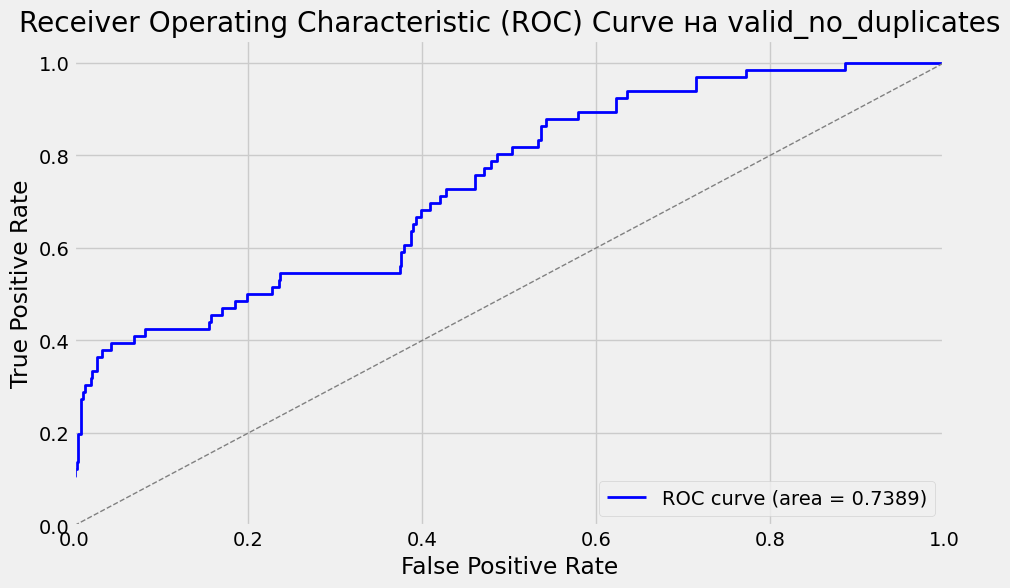

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_valid, valid_preds)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC (area = {roc_auc_score(y_valid, valid_preds):.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC на valid_no_duplicates')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
